## Generate the mesh

In [12]:
from mesh import three_cubes
from convert_mesh import convert_mesh

size = 0.05
three_cubes(f"meshes/mesh_{size}.msh", size=size)

volume_file = f"meshes/mesh_{size}.xdmf"
facet_file = f"meshes/mesh_{size}_facet.xdmf"
nb_cells, nb_facets = convert_mesh(f"meshes/mesh_{size}.msh", volume_file, facet_file)

Info    : Meshing 1D...nts                                                                                                             
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 60%] Meshing curve 16 (Line)
Info    : [ 60%] Meshing curve 17 (Line)
Info    : [ 70%] Meshing curve 18 (Line)
Info    : [ 70%] Meshing curve 19 (Line)
Info    : [ 70%] Meshing curve 20 (Line)
Info    : [ 80%] Meshing curve 21 (Line)
Info    : [ 

X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0



Surface IDs:  [4 5 6 7]
Volume IDs:  [1 2 3]


In [2]:
def run(volume_file, facet_file):
    from script_festim_2 import run_festim_2
    import time

    start = time.perf_counter()
    run_festim_2(volume_file, facet_file)
    end = time.perf_counter()

    elapsed_time = end - start


    return elapsed_time

In [13]:
import ipyparallel as ipp
import numpy as np


num_procs = [1, 2, 4, 8, 16]
runtimes = np.zeros_like(num_procs, dtype=np.float64)
for i, num_proc in enumerate(num_procs):
    print(f"Running with {num_proc} processes")
    cluster = ipp.Cluster(engines="mpi", n=num_proc)
    rc = cluster.start_and_connect_sync()

    query = rc[:].apply_async(run, volume_file, facet_file)
    query.wait()
    elapsed_times = query.get()
    print(elapsed_times)

    runtime = np.max(elapsed_times)
    print(f"Elapsed times: {elapsed_times} seconds, max {runtime=:.2e}")

    runtimes[i] = runtime

Running with 1 processes
Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 1/1 [00:05<00:00,  5.74s/engine]
[21.360985281000012]
Elapsed times: [21.360985281000012] seconds, max runtime=2.14e+01
Running with 2 processes
Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 2/2 [00:05<00:00,  2.72s/engine]
[15.315154433999965, 15.314556240999991]
Elapsed times: [15.315154433999965, 15.314556240999991] seconds, max runtime=1.53e+01
Running with 4 processes
Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 4/4 [00:05<00:00,  1.37s/engine]
[12.037515492000011, 12.03680190700004, 12.035378109000021, 12.036482700999954]
Elapsed times: [12.037515492000011, 12.03680190700004, 12.035378109000021, 12.036482700999954] seconds, max runtime=1.20e+01
Running with 8 processes
Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLaunch

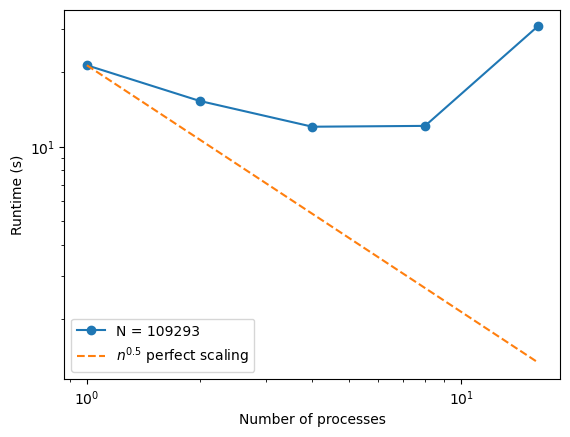

In [17]:
import matplotlib.pyplot as plt

plt.loglog(num_procs, runtimes, marker="o", label=f"N = {nb_cells}")

n = np.linspace(1, 16, 100)
plt.loglog(n, runtimes[0] * n[0] / n, linestyle="--", label="$n^{0.5}$ perfect scaling")

plt.xlabel("Number of processes")
plt.ylabel("Runtime (s)")

plt.legend()
plt.show()